# EDA 1: Finding Probabilities
## This notebook contains initial exploratory data analysis for a Pokemon Go shiny appearance odds calculator
### Author: Aaron Washington Chen

In [7]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

### Given Data/Parameters and Problem Formation

According to Silph Road (https://thesilphroad.com/science/pokemon-go-deducing-shiny-rate/), the general probability for finding a shiny in the wild is 1 in 450 appearances. This ignores special days/raids and also assumes that the Pokemon is able to be shiny in the first place. Because of their empirically sourced data (and because neither Niantic or Pokemon Company confirm or deny this number), I'm going to use this as the baseline.

In [8]:
P_shiny = 1/450
print(P_shiny)

0.0022222222222222222


It appears we have a rare event probability, which leads me to believe that this can be modeled with a Poisson distribution. 

This means that the probability for k shinies in a given interval can be found as:
P(k shinies) = (lambda^k * e^-lambda)/k!
where lambda is the expected value for finding shinies in that interval.

So, we must define an interval as well as find the expected value. 

---

### Defining an Interval

Since we have not recorded Pokemon seen, how many of them we saw, user info, etc, and only have an estimate for number of Pokemon seen, I will use an assumed Pokemon Sightings number for an interval. I play something like 1-2 hours a day (at the bare minimum, I'll play right when I wake up, sometimes when doing cardio, quickly at lunch, right before dinner, and right before bed). My rough guess is that I'll see 200 Pokemon a day.

My stats say I've caught 20,000 Pokemon since starting on January 20. That means 182 days. Now, caught is not the same number as appearances, so I'll need to add a padding factor to account for Pokemon that I don't catch. This can happen for a few reasons: they run, fail a shiny check, or are too difficult to catch.  It does not seem like Pokemon run very often, but I do shiny/difficulty checks somewhat often. Let's say...another 25% (or 5,000) fall into this category.

In [9]:
25000/182

137.36263736263737

This means I usually see something like 140 Pokemon a day! Sounds like a lot, but in my defense, my block has a total of 8 Pokestops and 3 gyms, so I can see a lot of Pokemon just going for a short (distance-wise) walk. 

---

### Expected Value

We need to find an expected value. Since we have the probability as given (and the events are independent), we need something that represents the outcome of finding a shiny. Let's use a boolean: 1 for finding a shiny. The expected value should be somewhat trivial to calculate:

In [15]:
def expected_shinies(appearances):
    # This function gives the number of expected shiny Pokemon appearances for 
    # a user-provided number of appearances of all Pokemon
    all_appearances = [1 for _ in range(1, appearances+1, 1)]
    P_shiny = 1/450 # from Silph Road
    weighted_P = np.multiply(P_shiny, all_appearances)
    return np.sum(weighted_P)

In [16]:
expected_shinies(25000)

55.55555555555555

In [20]:
expected_shinies(140)

0.31111111111111106

Wait, this is a binomial distribution as this is the value of n * p

In [21]:
def prob_poisson_shinies(k, appearances=140):
    # This function takes in the number of appearances (with a default of my daily rate of 140)
    # and the number of shinies you've gotten/want to get and gives back the probability 
    # assuming a Poisson distribution
    exp_val = expected_shinies(appearances)
    return exp_val**k * np.exp(-exp_val) / math.factorial(k)

In [48]:
prob_poisson_shinies(k=1, appearances=140)

0.22793010107442263

---

# Binomial Distribution?

In [ ]:
 25000 * 1/450

Let's try this again with a binomial distribution (to be fair, a Poisson distribution is a binomial distribution where the number of trials approaches infinity and the success rate approaches zero)

In [27]:
mean, var = scipy.stats.binom.stats(140, P_shiny)

In [30]:
print(mean)

0.3111111111111111


In [31]:
print(var)

0.3104197530864198


In [32]:
mean2, var2 = scipy.stats.binom.stats(25000, P_shiny)

In [33]:
print(mean2)
print(var2)

55.55555555555556
55.4320987654321


In [34]:
mean3, var3 = scipy.stats.binom.stats(250000, P_shiny)
print(mean3)
print(var3)

555.5555555555555
554.320987654321


In [35]:
mean4, var4 = scipy.stats.binom.stats(2500000, P_shiny)
print(mean4)
print(var4)

5555.555555555556
5543.20987654321


In [38]:
mean5, var5 = scipy.stats.binom.stats(2500000, 1/4096)
print(mean5)
print(var5)

610.3515625
610.2025508880615


In [39]:
mean6, var6 = scipy.stats.binom.stats(2500000, 1/8192)
print(mean6)
print(var6)

305.17578125
305.1385283470154


In [40]:
mean7, var7 = scipy.stats.binom.stats(2500000, 1/81920)
print(mean7)
print(var7)

30.517578125
30.517205595970154


In [46]:
def prob_binom_shinies(k, appearances=140):
    # This function takes in the number of appearances (with a default of my daily rate of 140)
    # and the number of shinies you've gotten/want to get and gives back the probability
    # assuming a binomial distribution
    coef = math.factorial(appearances) / (math.factorial(k) * math.factorial(appearances-k))
    P_shiny = 1/450
    return coef * P_shiny**k * (1-P_shiny)**(appearances-k)

In [49]:
print(prob_binom_shinies(k=0, appearances=140))

0.7323788801488637


---

In this case, since the expected value for the Poisson distribution is derived from the expected value for the binomial distribution, the resulting probabilities are not very different

In [72]:
def all_dists(num_looking, appearances=140):
    # This function takes in the number of appearances (with a default of my daily rate of 140)
    # and makes a loop to find the probabilities of finding shinies up to the number of 
    # appearances
    all_appearances = dict()
    
    for k in range(0, appearances+1, 1):
        all_appearances[k] = prob_poisson_shinies(k, appearances)
    
    #binoms = [prob_binom_shinies(k, appearances) for k in all_appearances]
    plt.plot(list(all_appearances.keys()), list(all_appearances.values()));
    plt.axvline(x=num_looking, color='red')
    plt.xlim(0,15)
    
    print(f'Probability of finding {num_looking} shinies in {appearances} is: {all_appearances[num_looking]}')

Probability of finding 3 shinies in 140 is: 0.003676897103752002


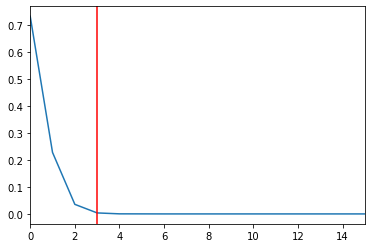

In [73]:
all_dists(num_looking=3, appearances=140)